# Load modules and data

In [1]:
#  Importing the main library for building model and its analysis
import xgboost as xgb
import seaborn as sns 
from scipy.stats import uniform, randint
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, f1_score, classification_report
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, train_test_split
from sklearn.datasets import make_classification

In [2]:
# Import Python  print function and division
from __future__ import print_function, division

# Import GDAL, NumPy, and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

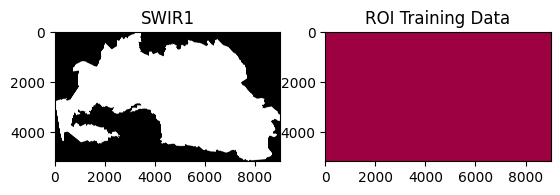

In [3]:
# Read in our image and ROI image
img_ds = gdal.Open('../Final_results/clip_united_2019.tif', gdal.GA_ReadOnly)
"""
This data collection includes the bands of sensors from Sentinel-2 satellite constellations: 
B2 - blue (wavelength centre of electromagnetic radiation on satellite A: 492 nm), 
B3 - green (560 nm), B4 - red (665 nm), B8 - near-infrared (NIR: 833 nm), B11 – far infrared-1 (SWIR-1: 1614 nm), 
B12 – far infrared-2 (SWIR-2: 2202 nm), and calculated vegetation indices: NDVI, NDWI, NBR 
and the difference between NBR 2019 and 2020 (attached to the 2020 data list); 
as well as added Sentinel-1 radar channels with polarization: VH, VV and the simple ratio between VV and VH (VV / VH).
"""

roi_ds = gdal.Open('../Final_results/final_train_sample_2019.tif', gdal.GA_ReadOnly)
"""
Identified landscape types in the formed training sample: 0 – water body, 1 – area without vegetation,
2 – meadow or fallow, 3 – swamp, 4 – single or groups of bushes and trees, 5 – forest, 6 – a deaded stand after fire damage, 7 – deaded stand without the influence of the pyrogenic factor
"""

# Copy the transformation to a variable
GT_input = img_ds.GetGeoTransform()

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
    
roi = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)

# Display them
plt.subplot(121)
plt.imshow(img[:, :, 4], cmap=plt.cm.Greys_r)
plt.title('SWIR1')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('ROI Training Data')

plt.show()

# Clean up RAM
img_ds = ""
roi_ds = ""


# Prepocessing of input data

In [4]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (roi > 0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(roi[roi > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

X = img[roi > 0]
y_interm = roi[roi > 0]
y = y_interm-1

print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

We have 2210 samples
The training data include 8 classes: [1 2 3 4 5 6 7 8]
Our X matrix is sized: (2210, 12)
Our y array is sized: (2210,)


In [5]:
# Convert data from array to pd dataframe

import pandas as pd

X = pd.DataFrame(X)
y = pd.DataFrame(y)

In [6]:
# Columns in "X" data collections
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0156,0.0325,0.0172,0.3176,0.1344,0.0557,0.897252,-0.814339,0.701581,-14.600834,-8.462929,0.579620
1,0.0213,0.0382,0.0254,0.2190,0.1045,0.0516,0.792144,-0.702955,0.618625,-13.584172,-8.335326,0.613606
2,0.0138,0.0356,0.0179,0.3118,0.1388,0.0575,0.891416,-0.795049,0.688600,-15.390807,-8.934840,0.580531
3,0.0128,0.0313,0.0167,0.2544,0.1400,0.0581,0.876798,-0.780889,0.628160,-13.377872,-7.742314,0.578740
4,0.0139,0.0348,0.0205,0.2452,0.1487,0.0660,0.845691,-0.751429,0.575835,-14.600150,-10.455448,0.716119


In [7]:
# Columns in "y" data collections
y.head()

,0
0,5
1,5
2,5
3,5
4,5


# Create first XGBoost model for estimate varibiality of output stats

In [8]:
# K-Folds cross-validation for estimation "quality" of input data for building model
X_kfold = pd.DataFrame(X).to_numpy()
y_kfold = pd.DataFrame(y).to_numpy()

In [9]:
# Function for comparing datasets on homogeneity 
def display_scores(scores):
    print("    Scores: {0}\n    Mean: {1:.3f}\n    Std: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

In [10]:
# Output results of K-Folds cross-validation for XGBoost model
kfold = KFold(n_splits=5, shuffle=True)
scores = []
for train_index, test_index in kfold.split(X_kfold):   
    X_train, X_test = X_kfold[train_index], X_kfold[test_index]
    y_train, y_test = y_kfold[train_index], y_kfold[test_index]

    xgb_model = xgb.XGBClassifier(objective="multi:softprob", eval_metric=['mlogloss'])
    xgb_model.fit(X_train, y_train)
    
    y_pred = xgb_model.predict(X_test)
      
    scores.append(accuracy_score(y_test, y_pred))
    
print('Accuracy classification score: \n')
display_scores(scores)
print('\n', 20*'-')

Accuracy classification score: 

    Scores: [0.8167420814479638, 0.8190045248868778, 0.8484162895927602, 0.8438914027149321, 0.8257918552036199]
    Mean: 0.831
    Std: 0.013

 --------------------


# Add optimal hyperparameters for XGBoost model

In [11]:
# Overwrite hyperparameters data for the next step/stage
p1 = 0.46263769780760494     # colsample_bytree
print('Colsample_bytree: ' + str(p1))

p2 = 0.4076530193693614                # gamma
print('Gamma: ' + str(p2))

p3 = 0.05713257641708951        # learning_rate
print('Learning_rate: ' + str(p3))

p4 = 6            # max_depth
print('Max_depth: ' + str(p4))

p5 = 77         # n_estimators
print('N_estimators: ' + str(p5))

p6 = 0.3601252948102243            # subsample
print('Subsample: ' + str(p6))

Colsample_bytree: 0.46263769780760494
Gamma: 0.4076530193693614
Learning_rate: 0.05713257641708951
Max_depth: 6
N_estimators: 77
Subsample: 0.3601252948102243


# Creating a basic XGBoost model for est. of uncertainties

In [12]:
# Create DMatrix (is an internal data structure) 
data_dmatrix = xgb.DMatrix(data=X,label=y)


 Iteration #1 

[0]	validation_0-mlogloss:1.92330	validation_1-mlogloss:1.92986
[1]	validation_0-mlogloss:1.79440	validation_1-mlogloss:1.80750
[2]	validation_0-mlogloss:1.68142	validation_1-mlogloss:1.69851
[3]	validation_0-mlogloss:1.58542	validation_1-mlogloss:1.60526
[4]	validation_0-mlogloss:1.49825	validation_1-mlogloss:1.52059
[5]	validation_0-mlogloss:1.42113	validation_1-mlogloss:1.44608
[6]	validation_0-mlogloss:1.35016	validation_1-mlogloss:1.37932
[7]	validation_0-mlogloss:1.28523	validation_1-mlogloss:1.31684
[8]	validation_0-mlogloss:1.22454	validation_1-mlogloss:1.25929
[9]	validation_0-mlogloss:1.17031	validation_1-mlogloss:1.20820
[10]	validation_0-mlogloss:1.11949	validation_1-mlogloss:1.16175
[11]	validation_0-mlogloss:1.07257	validation_1-mlogloss:1.11865
[12]	validation_0-mlogloss:1.02854	validation_1-mlogloss:1.07766
[13]	validation_0-mlogloss:0.98635	validation_1-mlogloss:1.03810
[14]	validation_0-mlogloss:0.94971	validation_1-mlogloss:1.00512
[15]	validation_0-

/home/dima/anaconda3/envs/GIS/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


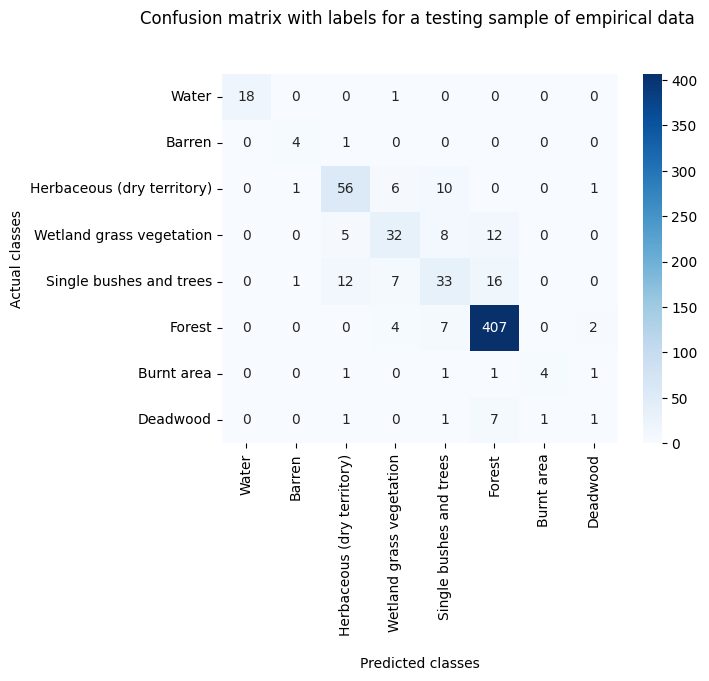

<Figure size 3000x3000 with 0 Axes>


 Iteration #2 

[0]	validation_0-mlogloss:1.92066	validation_1-mlogloss:1.93036
[1]	validation_0-mlogloss:1.78999	validation_1-mlogloss:1.80996
[2]	validation_0-mlogloss:1.67559	validation_1-mlogloss:1.70190
[3]	validation_0-mlogloss:1.57945	validation_1-mlogloss:1.61429
[4]	validation_0-mlogloss:1.48858	validation_1-mlogloss:1.53172
[5]	validation_0-mlogloss:1.40944	validation_1-mlogloss:1.45646
[6]	validation_0-mlogloss:1.33890	validation_1-mlogloss:1.39274
[7]	validation_0-mlogloss:1.27397	validation_1-mlogloss:1.33125
[8]	validation_0-mlogloss:1.21360	validation_1-mlogloss:1.27557
[9]	validation_0-mlogloss:1.15649	validation_1-mlogloss:1.22183
[10]	validation_0-mlogloss:1.10463	validation_1-mlogloss:1.17474
[11]	validation_0-mlogloss:1.05717	validation_1-mlogloss:1.13239
[12]	validation_0-mlogloss:1.01317	validation_1-mlogloss:1.09334
[13]	validation_0-mlogloss:0.97311	validation_1-mlogloss:1.05831
[14]	validation_0-mlogloss:0.93649	validation_1-mlogloss:1.02493
[15]	validation_0-

/home/dima/anaconda3/envs/GIS/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


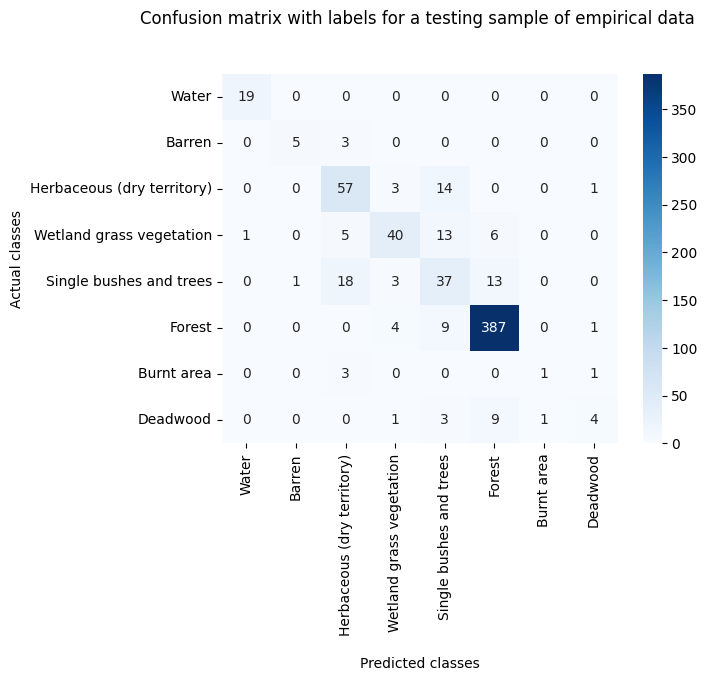

<Figure size 3000x3000 with 0 Axes>


 Iteration #3 

[0]	validation_0-mlogloss:1.92375	validation_1-mlogloss:1.93129
[1]	validation_0-mlogloss:1.79266	validation_1-mlogloss:1.80699
[2]	validation_0-mlogloss:1.67955	validation_1-mlogloss:1.70124
[3]	validation_0-mlogloss:1.58162	validation_1-mlogloss:1.60645
[4]	validation_0-mlogloss:1.49545	validation_1-mlogloss:1.52418
[5]	validation_0-mlogloss:1.41547	validation_1-mlogloss:1.44950
[6]	validation_0-mlogloss:1.34370	validation_1-mlogloss:1.38177
[7]	validation_0-mlogloss:1.27741	validation_1-mlogloss:1.32045
[8]	validation_0-mlogloss:1.21856	validation_1-mlogloss:1.26697
[9]	validation_0-mlogloss:1.16440	validation_1-mlogloss:1.21574
[10]	validation_0-mlogloss:1.11399	validation_1-mlogloss:1.16875
[11]	validation_0-mlogloss:1.06730	validation_1-mlogloss:1.12674
[12]	validation_0-mlogloss:1.02277	validation_1-mlogloss:1.08518
[13]	validation_0-mlogloss:0.98159	validation_1-mlogloss:1.04767
[14]	validation_0-mlogloss:0.94539	validation_1-mlogloss:1.01511
[15]	validation_0-

/home/dima/anaconda3/envs/GIS/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


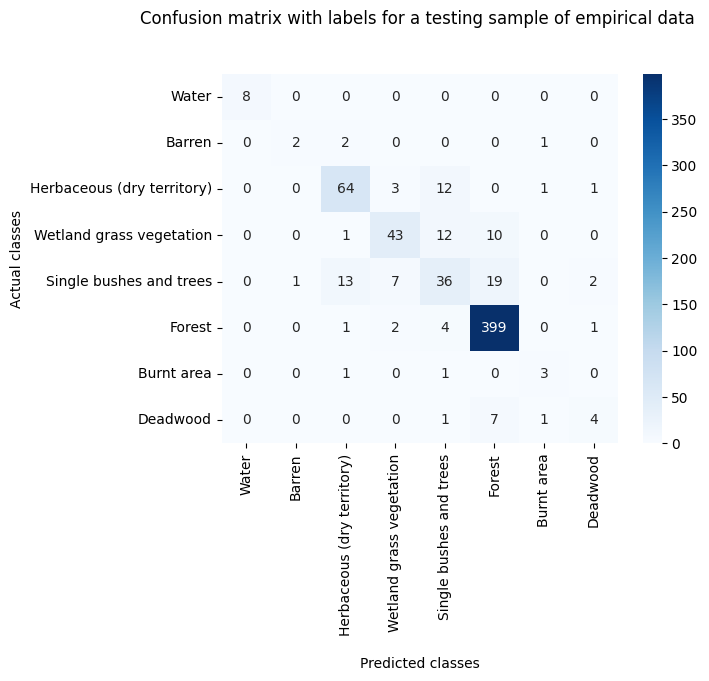

<Figure size 3000x3000 with 0 Axes>


 Iteration #4 

[0]	validation_0-mlogloss:1.92560	validation_1-mlogloss:1.93076
[1]	validation_0-mlogloss:1.79721	validation_1-mlogloss:1.80757
[2]	validation_0-mlogloss:1.68689	validation_1-mlogloss:1.70069
[3]	validation_0-mlogloss:1.58632	validation_1-mlogloss:1.60370
[4]	validation_0-mlogloss:1.49867	validation_1-mlogloss:1.52021
[5]	validation_0-mlogloss:1.42060	validation_1-mlogloss:1.44827
[6]	validation_0-mlogloss:1.34793	validation_1-mlogloss:1.38133
[7]	validation_0-mlogloss:1.28307	validation_1-mlogloss:1.31934
[8]	validation_0-mlogloss:1.22293	validation_1-mlogloss:1.26076
[9]	validation_0-mlogloss:1.16789	validation_1-mlogloss:1.21031
[10]	validation_0-mlogloss:1.11694	validation_1-mlogloss:1.16398
[11]	validation_0-mlogloss:1.06967	validation_1-mlogloss:1.11972
[12]	validation_0-mlogloss:1.02628	validation_1-mlogloss:1.08108
[13]	validation_0-mlogloss:0.98550	validation_1-mlogloss:1.04383
[14]	validation_0-mlogloss:0.94759	validation_1-mlogloss:1.00930
[15]	validation_0-

/home/dima/anaconda3/envs/GIS/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


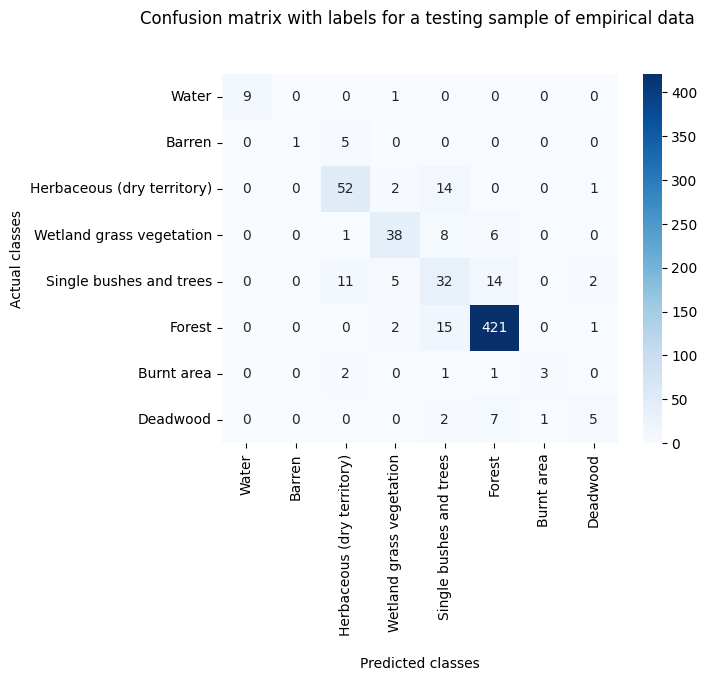

<Figure size 3000x3000 with 0 Axes>


 Iteration #5 

[0]	validation_0-mlogloss:1.92266	validation_1-mlogloss:1.92441
[1]	validation_0-mlogloss:1.79551	validation_1-mlogloss:1.79981
[2]	validation_0-mlogloss:1.68180	validation_1-mlogloss:1.68991
[3]	validation_0-mlogloss:1.58480	validation_1-mlogloss:1.59777
[4]	validation_0-mlogloss:1.49776	validation_1-mlogloss:1.51494
[5]	validation_0-mlogloss:1.42159	validation_1-mlogloss:1.44302
[6]	validation_0-mlogloss:1.34926	validation_1-mlogloss:1.37127
[7]	validation_0-mlogloss:1.28617	validation_1-mlogloss:1.31207
[8]	validation_0-mlogloss:1.22670	validation_1-mlogloss:1.25443
[9]	validation_0-mlogloss:1.17086	validation_1-mlogloss:1.20155
[10]	validation_0-mlogloss:1.12145	validation_1-mlogloss:1.15562
[11]	validation_0-mlogloss:1.07501	validation_1-mlogloss:1.11096
[12]	validation_0-mlogloss:1.03040	validation_1-mlogloss:1.06950
[13]	validation_0-mlogloss:0.99078	validation_1-mlogloss:1.03259
[14]	validation_0-mlogloss:0.95277	validation_1-mlogloss:0.99710
[15]	validation_0-

/home/dima/anaconda3/envs/GIS/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


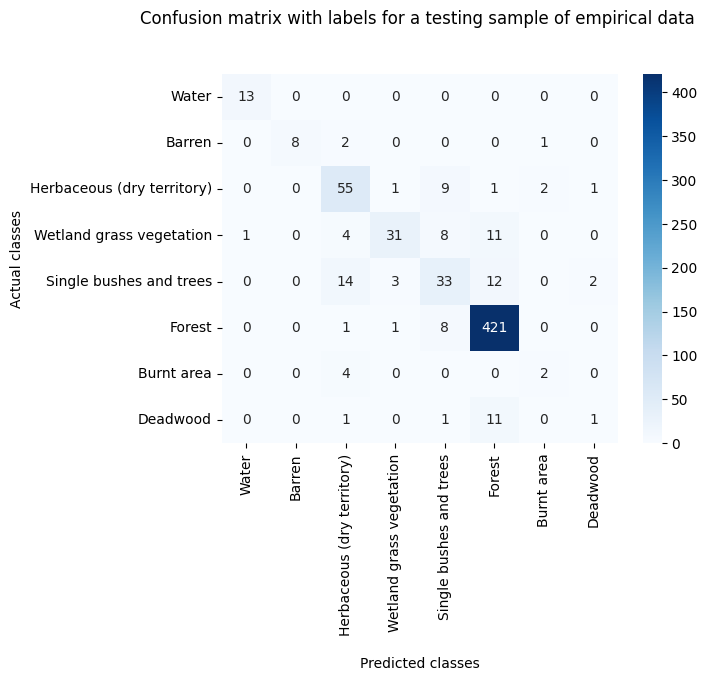

<Figure size 3000x3000 with 0 Axes>


 Iteration #6 

[0]	validation_0-mlogloss:1.92549	validation_1-mlogloss:1.93093
[1]	validation_0-mlogloss:1.79982	validation_1-mlogloss:1.80995
[2]	validation_0-mlogloss:1.68532	validation_1-mlogloss:1.70016
[3]	validation_0-mlogloss:1.58882	validation_1-mlogloss:1.60543
[4]	validation_0-mlogloss:1.49942	validation_1-mlogloss:1.51941
[5]	validation_0-mlogloss:1.42172	validation_1-mlogloss:1.44724
[6]	validation_0-mlogloss:1.35022	validation_1-mlogloss:1.37740
[7]	validation_0-mlogloss:1.28532	validation_1-mlogloss:1.31581
[8]	validation_0-mlogloss:1.22618	validation_1-mlogloss:1.26068
[9]	validation_0-mlogloss:1.16971	validation_1-mlogloss:1.20723
[10]	validation_0-mlogloss:1.11976	validation_1-mlogloss:1.15979
[11]	validation_0-mlogloss:1.07224	validation_1-mlogloss:1.11595
[12]	validation_0-mlogloss:1.02817	validation_1-mlogloss:1.07559
[13]	validation_0-mlogloss:0.98631	validation_1-mlogloss:1.03711
[14]	validation_0-mlogloss:0.94984	validation_1-mlogloss:1.00273
[15]	validation_0-

/home/dima/anaconda3/envs/GIS/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


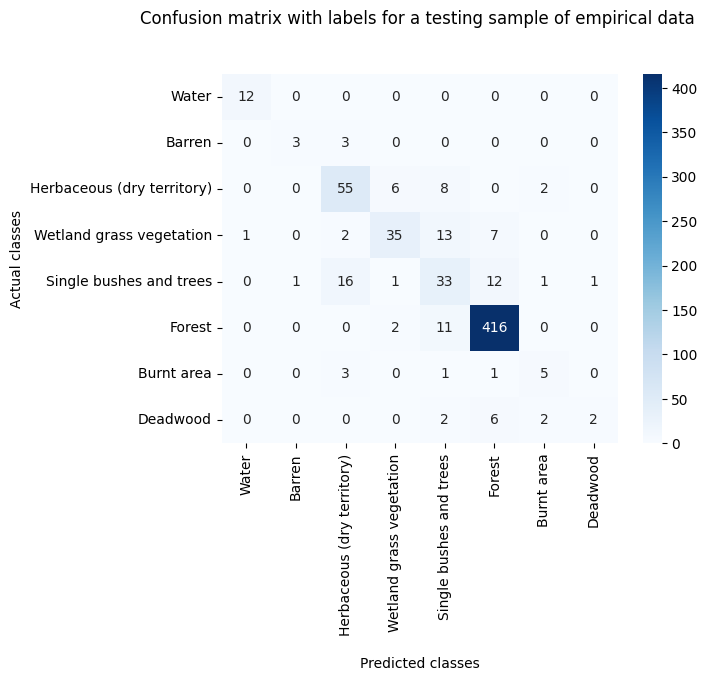

<Figure size 3000x3000 with 0 Axes>


 Iteration #7 

[0]	validation_0-mlogloss:1.92204	validation_1-mlogloss:1.93154
[1]	validation_0-mlogloss:1.79216	validation_1-mlogloss:1.81097
[2]	validation_0-mlogloss:1.67969	validation_1-mlogloss:1.70441
[3]	validation_0-mlogloss:1.58112	validation_1-mlogloss:1.61167
[4]	validation_0-mlogloss:1.49143	validation_1-mlogloss:1.52604
[5]	validation_0-mlogloss:1.41374	validation_1-mlogloss:1.45268
[6]	validation_0-mlogloss:1.34282	validation_1-mlogloss:1.38674
[7]	validation_0-mlogloss:1.27904	validation_1-mlogloss:1.32602
[8]	validation_0-mlogloss:1.22081	validation_1-mlogloss:1.27207
[9]	validation_0-mlogloss:1.16593	validation_1-mlogloss:1.22127
[10]	validation_0-mlogloss:1.11630	validation_1-mlogloss:1.17348
[11]	validation_0-mlogloss:1.06898	validation_1-mlogloss:1.13150
[12]	validation_0-mlogloss:1.02512	validation_1-mlogloss:1.09165
[13]	validation_0-mlogloss:0.98414	validation_1-mlogloss:1.05452
[14]	validation_0-mlogloss:0.94690	validation_1-mlogloss:1.02092
[15]	validation_0-

/home/dima/anaconda3/envs/GIS/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


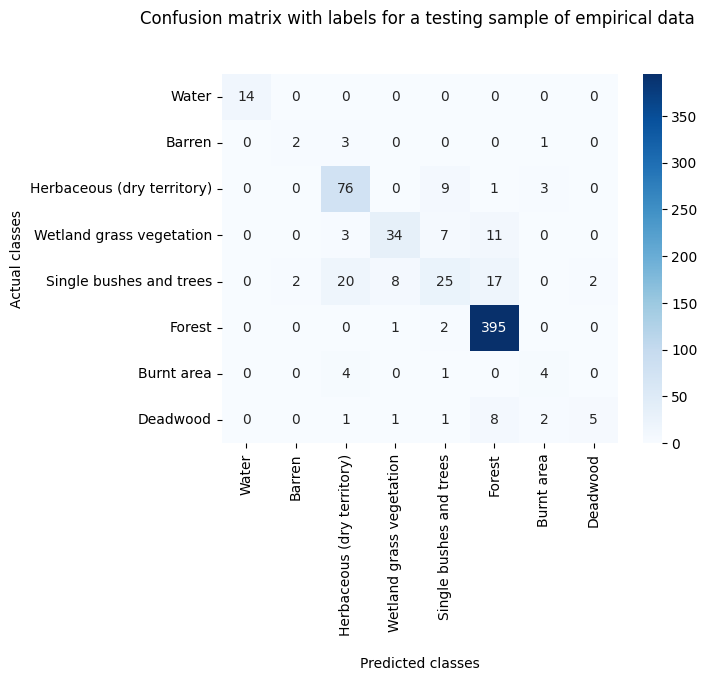

<Figure size 3000x3000 with 0 Axes>


 Iteration #8 

[0]	validation_0-mlogloss:1.92225	validation_1-mlogloss:1.92965
[1]	validation_0-mlogloss:1.79434	validation_1-mlogloss:1.80566
[2]	validation_0-mlogloss:1.68248	validation_1-mlogloss:1.69912
[3]	validation_0-mlogloss:1.58445	validation_1-mlogloss:1.60387
[4]	validation_0-mlogloss:1.49803	validation_1-mlogloss:1.52104
[5]	validation_0-mlogloss:1.42062	validation_1-mlogloss:1.44830
[6]	validation_0-mlogloss:1.35087	validation_1-mlogloss:1.38056
[7]	validation_0-mlogloss:1.28639	validation_1-mlogloss:1.31800
[8]	validation_0-mlogloss:1.22681	validation_1-mlogloss:1.26218
[9]	validation_0-mlogloss:1.17218	validation_1-mlogloss:1.21023
[10]	validation_0-mlogloss:1.12277	validation_1-mlogloss:1.16558
[11]	validation_0-mlogloss:1.07581	validation_1-mlogloss:1.12057
[12]	validation_0-mlogloss:1.03159	validation_1-mlogloss:1.07936
[13]	validation_0-mlogloss:0.99216	validation_1-mlogloss:1.04139
[14]	validation_0-mlogloss:0.95579	validation_1-mlogloss:1.00767
[15]	validation_0-

/home/dima/anaconda3/envs/GIS/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


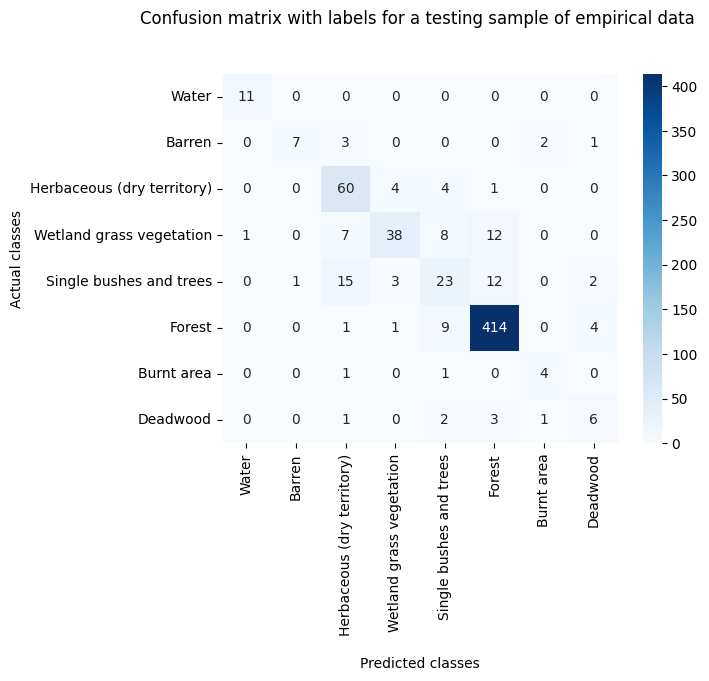

<Figure size 3000x3000 with 0 Axes>


 Iteration #9 

[0]	validation_0-mlogloss:1.92452	validation_1-mlogloss:1.92706
[1]	validation_0-mlogloss:1.79667	validation_1-mlogloss:1.80425
[2]	validation_0-mlogloss:1.68312	validation_1-mlogloss:1.69281
[3]	validation_0-mlogloss:1.58293	validation_1-mlogloss:1.59749
[4]	validation_0-mlogloss:1.49556	validation_1-mlogloss:1.51363
[5]	validation_0-mlogloss:1.41742	validation_1-mlogloss:1.44016
[6]	validation_0-mlogloss:1.34375	validation_1-mlogloss:1.37210
[7]	validation_0-mlogloss:1.28062	validation_1-mlogloss:1.30946
[8]	validation_0-mlogloss:1.22112	validation_1-mlogloss:1.25238
[9]	validation_0-mlogloss:1.16601	validation_1-mlogloss:1.19941
[10]	validation_0-mlogloss:1.11776	validation_1-mlogloss:1.15304
[11]	validation_0-mlogloss:1.06960	validation_1-mlogloss:1.10853
[12]	validation_0-mlogloss:1.02672	validation_1-mlogloss:1.06738
[13]	validation_0-mlogloss:0.98669	validation_1-mlogloss:1.03013
[14]	validation_0-mlogloss:0.94985	validation_1-mlogloss:0.99553
[15]	validation_0-

/home/dima/anaconda3/envs/GIS/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


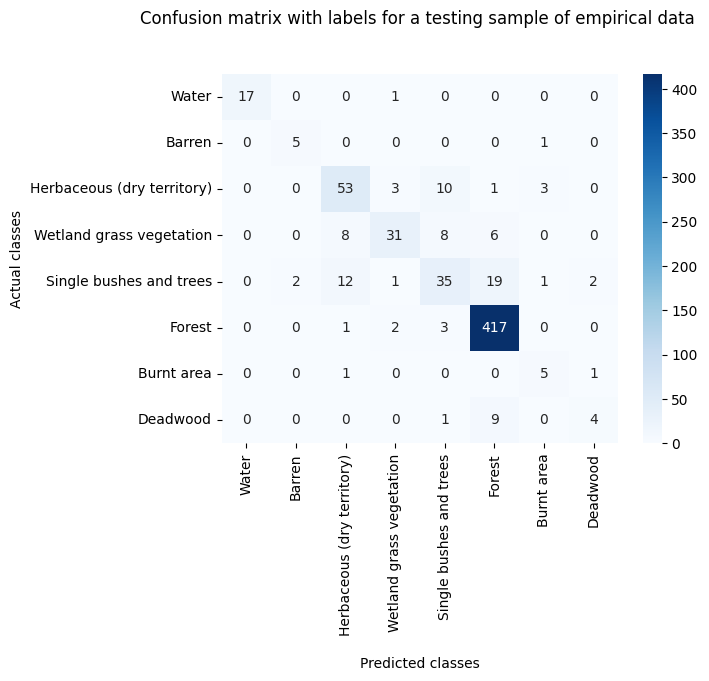

<Figure size 3000x3000 with 0 Axes>


 Iteration #10 

[0]	validation_0-mlogloss:1.91702	validation_1-mlogloss:1.93357
[1]	validation_0-mlogloss:1.78600	validation_1-mlogloss:1.81358
[2]	validation_0-mlogloss:1.67058	validation_1-mlogloss:1.70927
[3]	validation_0-mlogloss:1.57125	validation_1-mlogloss:1.61857
[4]	validation_0-mlogloss:1.48246	validation_1-mlogloss:1.53793
[5]	validation_0-mlogloss:1.40262	validation_1-mlogloss:1.46450
[6]	validation_0-mlogloss:1.33049	validation_1-mlogloss:1.39906
[7]	validation_0-mlogloss:1.26579	validation_1-mlogloss:1.34020
[8]	validation_0-mlogloss:1.20558	validation_1-mlogloss:1.28665
[9]	validation_0-mlogloss:1.14974	validation_1-mlogloss:1.23511
[10]	validation_0-mlogloss:1.09828	validation_1-mlogloss:1.18828
[11]	validation_0-mlogloss:1.05102	validation_1-mlogloss:1.14588
[12]	validation_0-mlogloss:1.00719	validation_1-mlogloss:1.10616
[13]	validation_0-mlogloss:0.96684	validation_1-mlogloss:1.07165
[14]	validation_0-mlogloss:0.93016	validation_1-mlogloss:1.03907
[15]	validation_0

/home/dima/anaconda3/envs/GIS/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


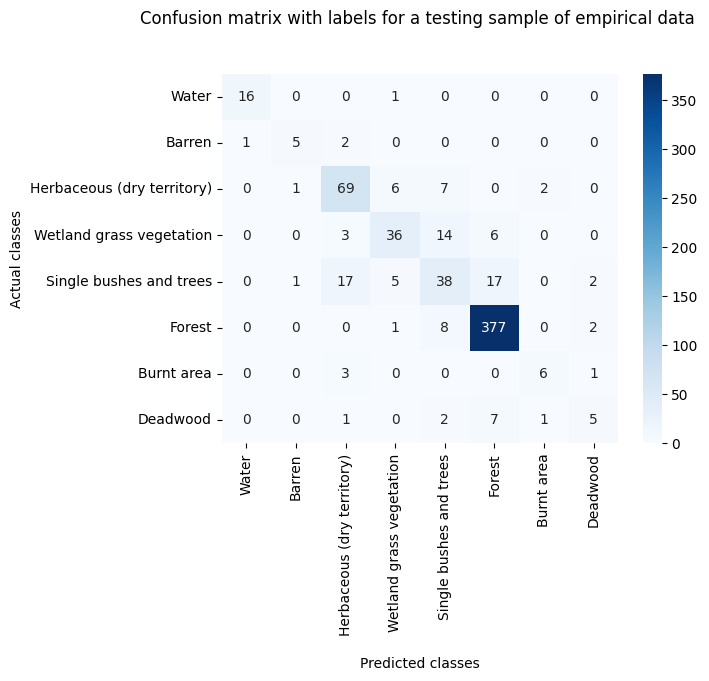

<Figure size 3000x3000 with 0 Axes>

In [13]:
# Create 10 traning iteration

for i in range (10):
    print("\n", f"Iteration #{i+1}", "\n")
    # Generate test and training samples
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    # Implementation of the scikit-learn API for XGBoost regression
    xgb_model = xgb.XGBClassifier(objective="multi:softprob", colsample_bytree=p1, gamma=p2, learning_rate=p3, 
                          max_depth=p4, n_estimators=p5, subsample=p6, eval_metric=['mlogloss'])
    
    # Fitting the model 
    xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])
    # learning dynamics
    y_pred = xgb_model.predict(X_test, ntree_limit=xgb_model.best_ntree_limit)
    
    print('Model XGboost report for testing data:') 
    print(classification_report(y_test, y_pred))
    
    # Create confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt="d")

    ax.set_title('Confusion matrix with labels for a testing sample of empirical data \n\n');
    ax.set_xlabel('\nPredicted classes')
    ax.set_ylabel('Actual classes');

    # Name`s class list
    ax.xaxis.set_ticklabels(['Water', 'Barren', 'Herbaceous (dry territory)', 'Wetland grass vegetation', 'Single bushes and trees', 'Forest', 
                         'Burnt area', 'Deadwood'])
    ax.yaxis.set_ticklabels(['Water', 'Barren', 'Herbaceous (dry territory)', 'Wetland grass vegetation', 'Single bushes and trees', 'Forest', 
                         'Burnt area', 'Deadwood'])

    ## Display the visualization of the Confusion Matrix
    plt.xticks(rotation=90) 
    plt.yticks(rotation=0) 
    plt.figure(figsize =(30, 30))
    plt.show()

# Create and estimation of a final XGBoost model

[0]	validation_0-mlogloss:1.91894
[1]	validation_0-mlogloss:1.78398
[2]	validation_0-mlogloss:1.66876
[3]	validation_0-mlogloss:1.57170
[4]	validation_0-mlogloss:1.48552
[5]	validation_0-mlogloss:1.40600
[6]	validation_0-mlogloss:1.33446
[7]	validation_0-mlogloss:1.26844
[8]	validation_0-mlogloss:1.21031
[9]	validation_0-mlogloss:1.15718
[10]	validation_0-mlogloss:1.10706
[11]	validation_0-mlogloss:1.06207
[12]	validation_0-mlogloss:1.01736
[13]	validation_0-mlogloss:0.97684
[14]	validation_0-mlogloss:0.93917
[15]	validation_0-mlogloss:0.90404
[16]	validation_0-mlogloss:0.87137
[17]	validation_0-mlogloss:0.84108
[18]	validation_0-mlogloss:0.81339
[19]	validation_0-mlogloss:0.78605
[20]	validation_0-mlogloss:0.76022
[21]	validation_0-mlogloss:0.73627
[22]	validation_0-mlogloss:0.71392
[23]	validation_0-mlogloss:0.69196
[24]	validation_0-mlogloss:0.67168
[25]	validation_0-mlogloss:0.65179
[26]	validation_0-mlogloss:0.63368
[27]	validation_0-mlogloss:0.61571
[28]	validation_0-mlogloss:0.5

/home/dima/anaconda3/envs/GIS/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


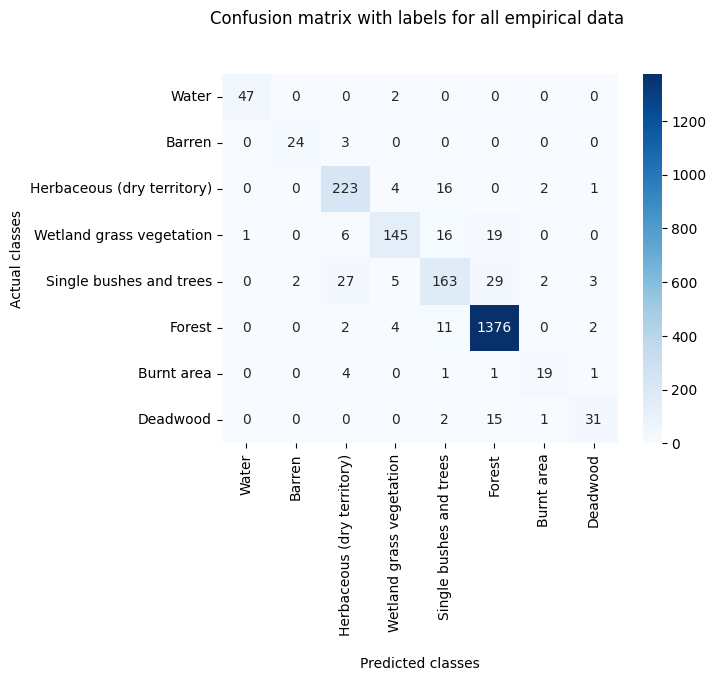

<Figure size 3000x3000 with 0 Axes>

In [14]:
# Fitting the model 
xgb_model.fit(X, y, eval_set=[(X, y)])
# learning dynamics
y_pred = xgb_model.predict(X, ntree_limit=xgb_model.best_ntree_limit)
    
print('\nModel XGboost report for all obs.:') 
print(classification_report(y, y_pred))
    
# Create confusion matrix
cf_matrix = confusion_matrix(y, y_pred)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt="d")

ax.set_title('Confusion matrix with labels for all empirical data \n\n');
ax.set_xlabel('\nPredicted classes')
ax.set_ylabel('Actual classes');

# Name`s class list
ax.xaxis.set_ticklabels(['Water', 'Barren', 'Herbaceous (dry territory)', 'Wetland grass vegetation', 'Single bushes and trees', 'Forest', 
                         'Burnt area', 'Deadwood'])
ax.yaxis.set_ticklabels(['Water', 'Barren', 'Herbaceous (dry territory)', 'Wetland grass vegetation', 'Single bushes and trees', 'Forest', 
                         'Burnt area', 'Deadwood'])

## Display the visualization of the Confusion Matrix
plt.xticks(rotation=90) 
plt.yticks(rotation=0) 
plt.figure(figsize =(30, 30))
plt.show()

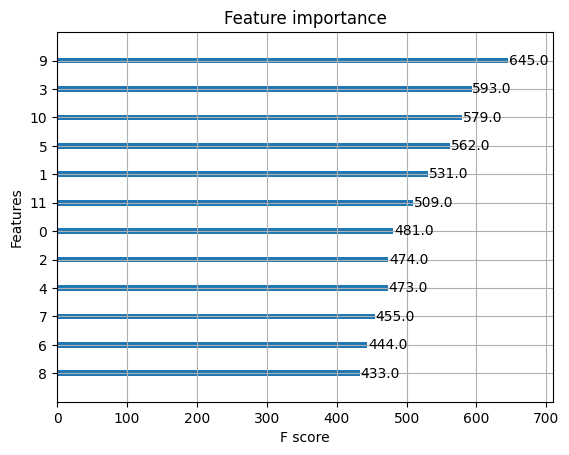

In [15]:
# Importance is calculated as: ”weight” is the number of times a feature appears in a trees
xgb.plot_importance(xgb_model, importance_type='weight')
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

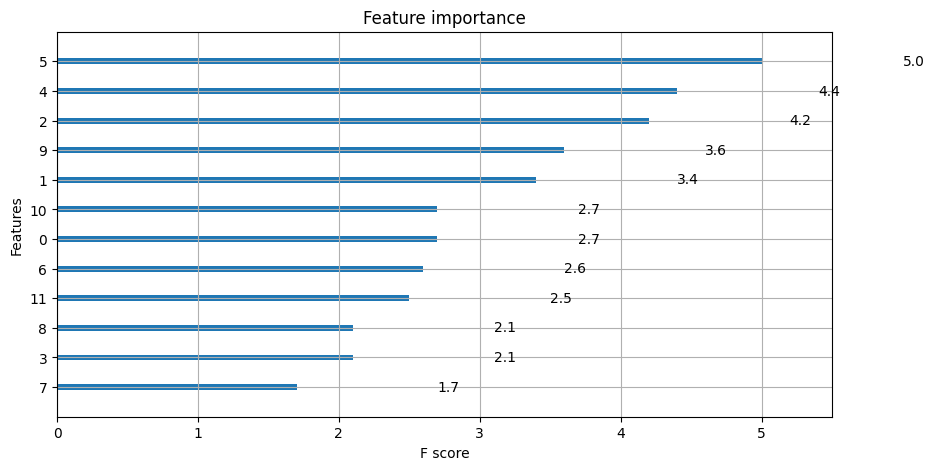

In [16]:
# Importance is calculated as: ”gain” is the average gain of splits which use the feature
# Get the booster from the xgbmodel
booster = xgb_model.get_booster()

# Get the importance dictionary (by gain) from the booster
importance = booster.get_score(importance_type="gain")

# make your changes
for key in importance.keys():
    importance[key] = round(importance[key], 1)

# provide the importance dictionary to the plotting function
ax = xgb.plot_importance(importance, importance_type='gain', show_values=True)
plt.rcParams['figure.figsize'] = [5, 6]

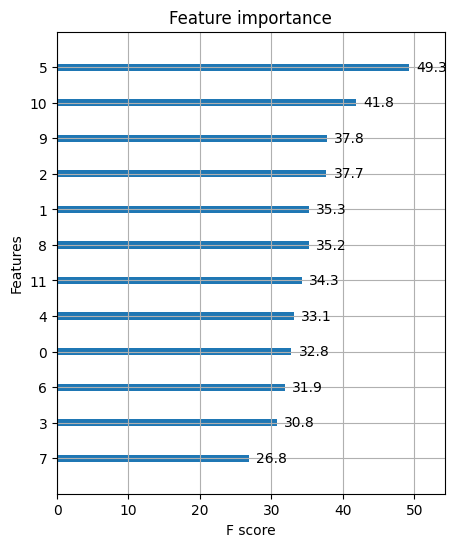

In [17]:
# Importance is calculated as: "cover” is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split
# Get the booster from the xgbmodel
booster = xgb_model.get_booster()

# Get the importance dictionary (by gain) from the booster
importance = booster.get_score(importance_type="cover")

# make your changes
for key in importance.keys():
    importance[key] = round(importance[key],1)

# provide the importance dictionary to the plotting function
ax = xgb.plot_importance(importance, importance_type='cover', show_values=True)
plt.rcParams['figure.figsize'] = [10, 5]

# SHAP method

In [18]:
# Load SHAP`s library
import shap

In [19]:
# Сreate an уxplainer object
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


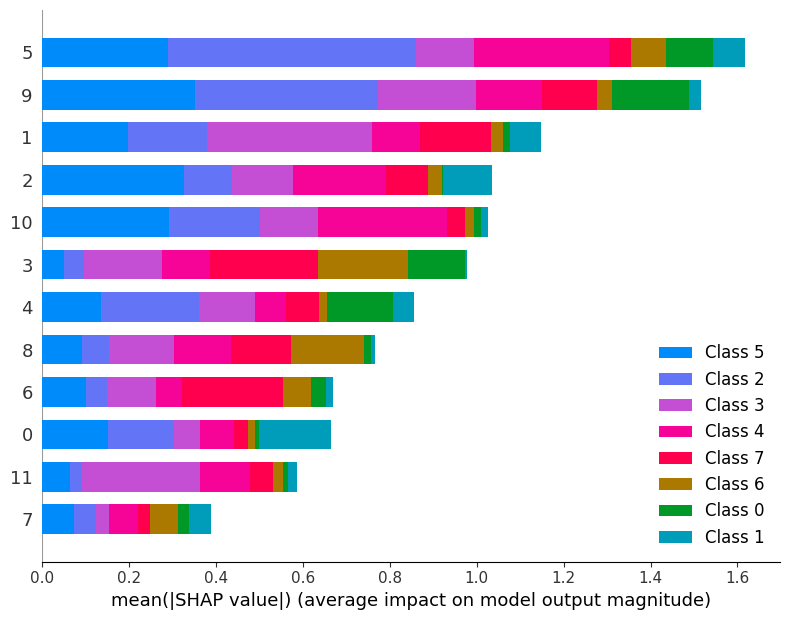

In [20]:
# Mean absolute value of the SHAP values for each feature 
shap.summary_plot(shap_values, X, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


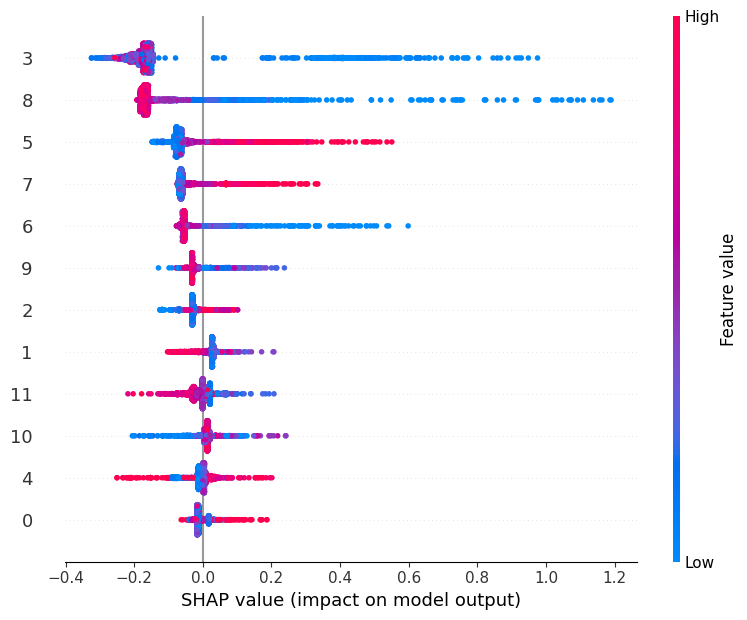

In [21]:
# Graph that summarises the effects of individual features (shap.values[feature])
shap.summary_plot(shap_values[6], X)

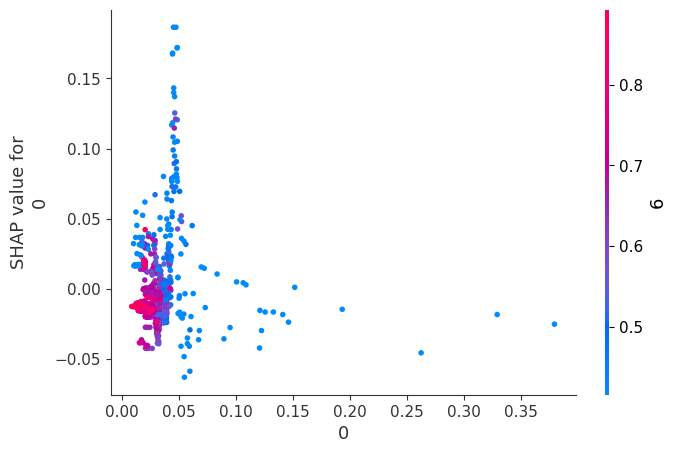

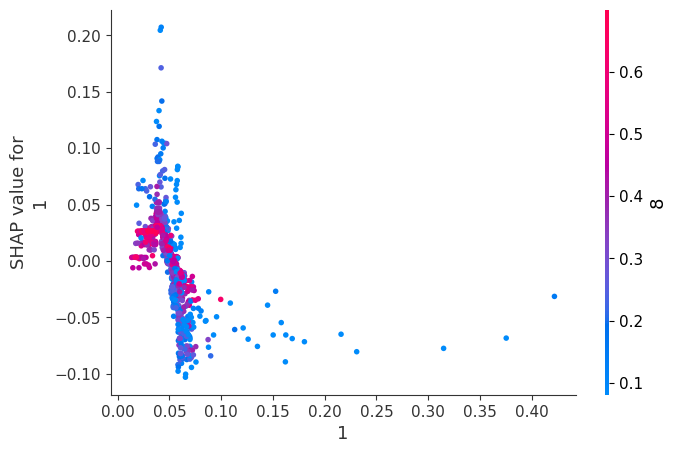

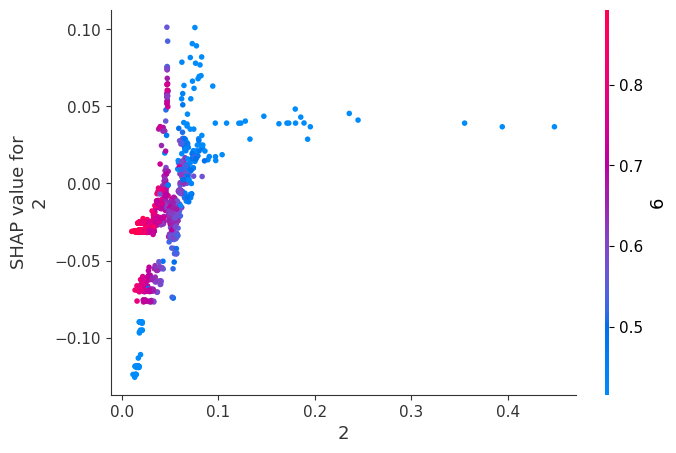

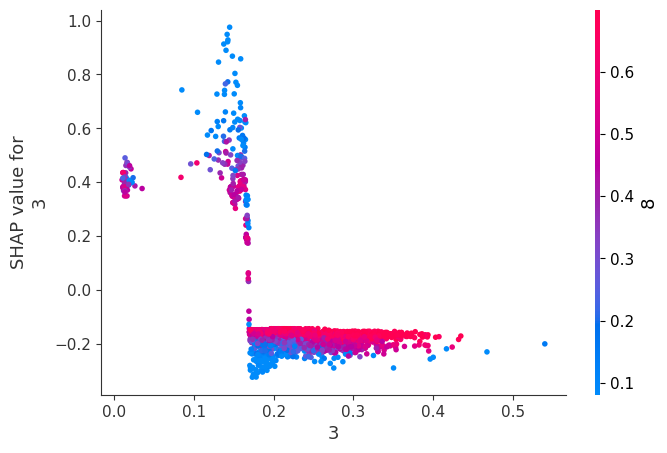

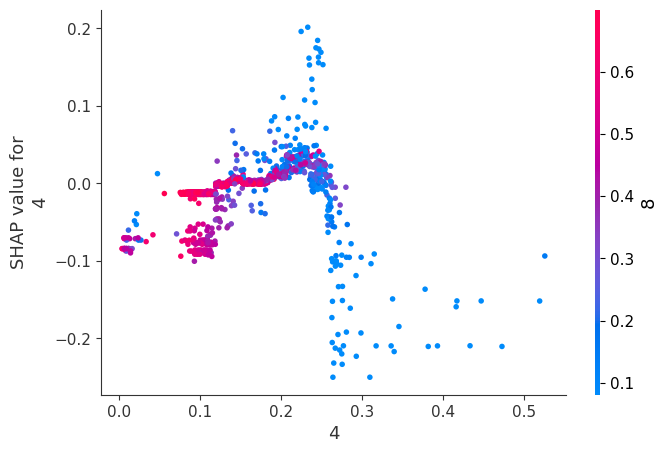

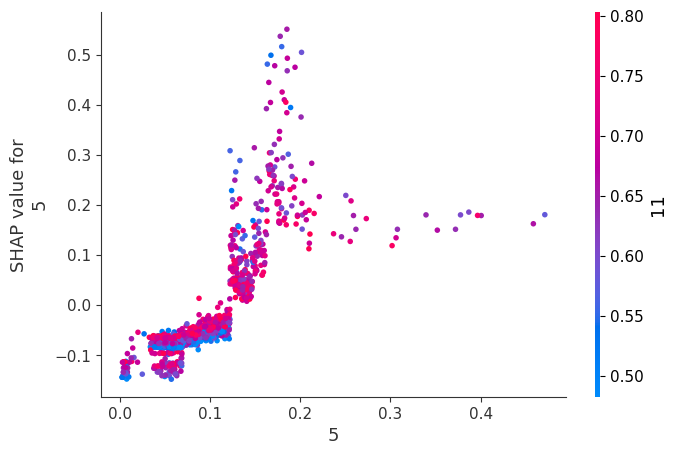

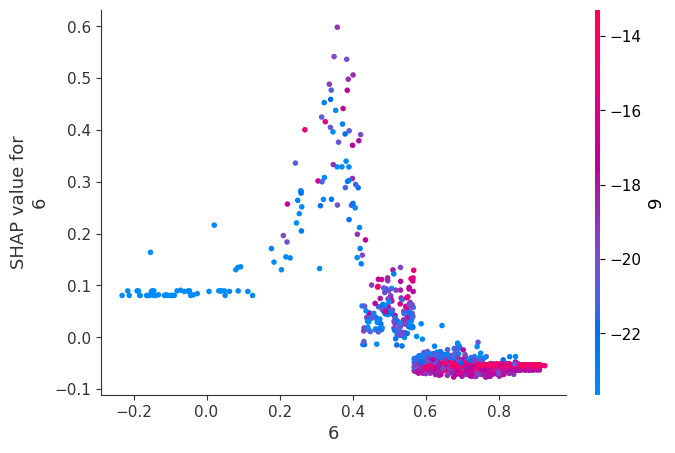

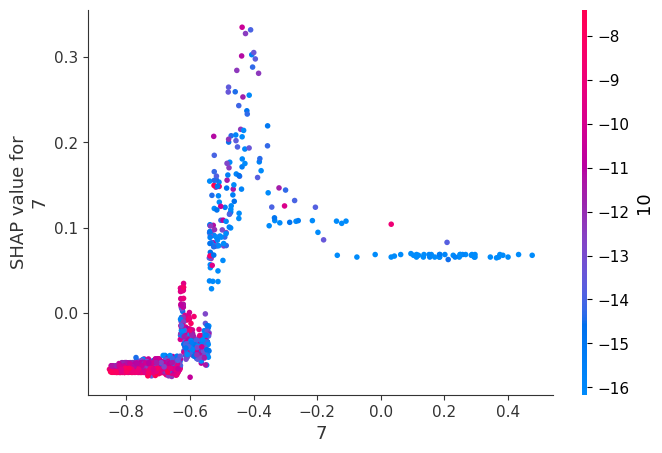

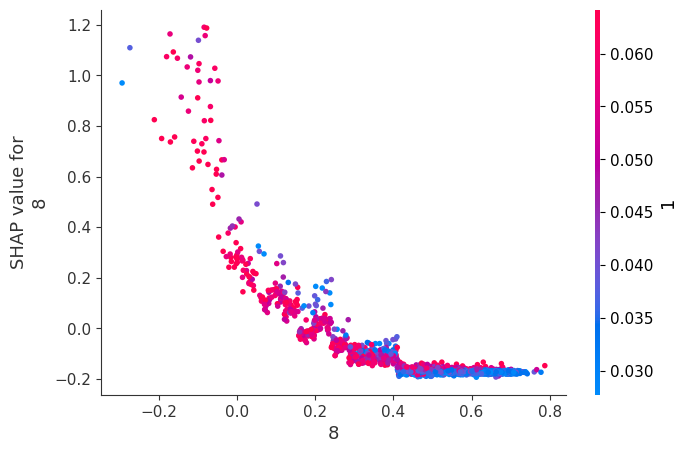

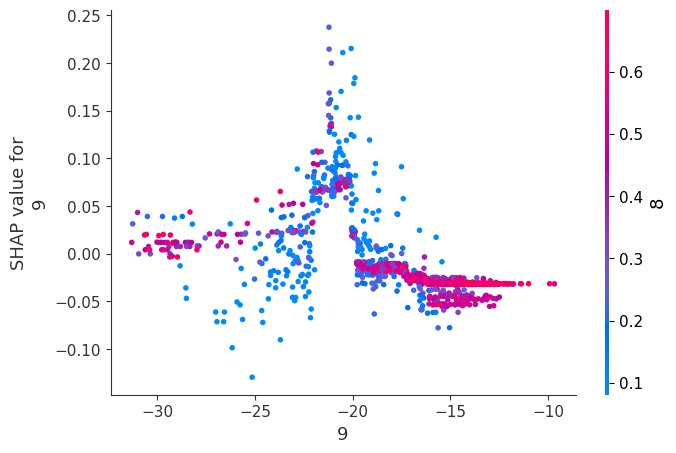

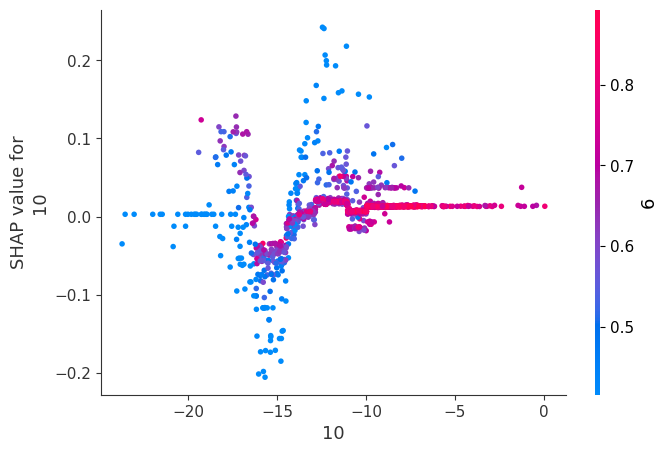

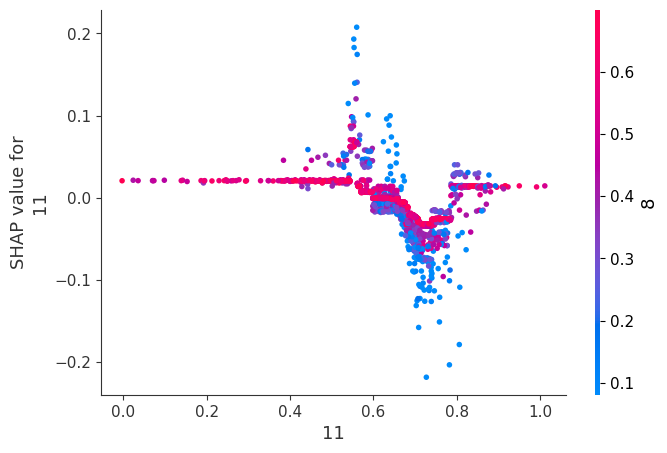

In [22]:
# Create a dependence scatter plot to show the effect of a single feature across the whole dataset
for name in X_train.columns:
    shap.dependence_plot(name, shap_values[6], X, color=shap_values)

# Save XGBoost model

In [23]:
# Save to JSON
xgb_model.save_model("../Final_results/xgb_model_Sentinel_classific_2019.json")
# Save to text format
xgb_model.save_model("../Final_results/xgb_model_Sentinel_classific_2019.txt")

# Classification of all interest territory

In [24]:
# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img.shape[0] * img.shape[1], img.shape[2])

img_as_array = img.reshape(new_shape)
new_shape = ""
print('Reshaped from {o} to {n}'.format(o=img.shape,
                                        n=img_as_array.shape))

Reshaped from (5161, 9008, 12) to (46490288, 12)


In [25]:
# Now predict for each pixel
class_prediction = xgb_model.predict(img_as_array)
img_as_array = ""

# Reshape our classification map
class_prediction = class_prediction.reshape(img[:, :, 0].shape)

In [ ]:
# Visualize

# First setup a 3-2-1 composite
def color_stretch(image, index, minmax=(-20, 1)):
    colors = image[:, :, index].astype(np.float64)

    max_val = minmax[1]
    min_val = minmax[0]

    # Enforce maximum and minimum values
    colors[colors[:, :, :] > max_val] = max_val
    colors[colors[:, :, :] < min_val] = min_val

    for b in range(colors.shape[2]):
        colors[:, :, b] = colors[:, :, b] * 1 / (max_val - min_val)
        
    return colors
    
img321 = color_stretch(img, [3, 2, 1], (0, 1))

# See https://github.com/matplotlib/matplotlib/issues/844/
n = class_prediction.max()
# Next setup a colormap for our map
colors = dict((
    (0, (0, 0, 255, 255)),  # Water
    (1, (0, 0, 0, 255)),  # Barren
    (2, (0, 100, 100, 255)),  # Herbaceous (dry teritory)
    (3, (0, 255, 255, 255)),  # Wetland grass vegetation
    (4, (160, 82, 45, 255)), # Single bushes and trees
    (5, (0, 255, 0, 255)),  # Forest
    (6, (255, 0, 0, 255)),  # Burnt area
    (7, (0, 0, 100, 255)),  # Deadwood    
))

# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n + 1)]
cmap = plt.matplotlib.colors.ListedColormap(index_colors)

# Now show the classmap next to the image
plt.subplot(121)
plt.imshow(img321)

plt.subplot(122)
plt.imshow(class_prediction, cmap=cmap, interpolation='none')

plt.show()

# Save classification raster

In [26]:
import rasterio

In [27]:
# Save classification raster
from affine import Affine
af_transf = Affine.from_gdal(*GT_input)

with rasterio.open(
    '../Final_results/classif_map_2019.tif',
    'w',
    driver='GTiff',
    height=class_prediction.shape[0],
    width=class_prediction.shape[1],
    count=1,
    dtype=np.float32,
    transform=af_transf
) as dest_file:
    dest_file.write(class_prediction, 1)
dest_file.close()